In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.inspection import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect= True)

C:\Users\jaski\AppData\Local\Temp\ipykernel_5864\2780334488.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect= True)


In [6]:
# reflect the tables
Measurement = Base.classes.measurement
Station= Base.classes.station

In [7]:
# View all of the classes that automap found
for name, cls in Base.classes.items():
    print(name)

station
measurement


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()
# session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
inspector = inspect(engine)

columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
inpector = inspect(engine)

columns_measurement = inspector.get_columns('measurement')
for column in columns_measurement:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
tables = inspector.get_table_names()
tables

['measurement', 'station']

In [13]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [14]:
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago

DatetimeIndex(['2016-08-23'], dtype='datetime64[ns]', freq=None)

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
one_year_ago_datetime = one_year_ago.to_pydatetime()

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_datetime).filter(Measurement.prcp != None).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurements_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
measurements_df= measurements_df.sort_values(by='date')


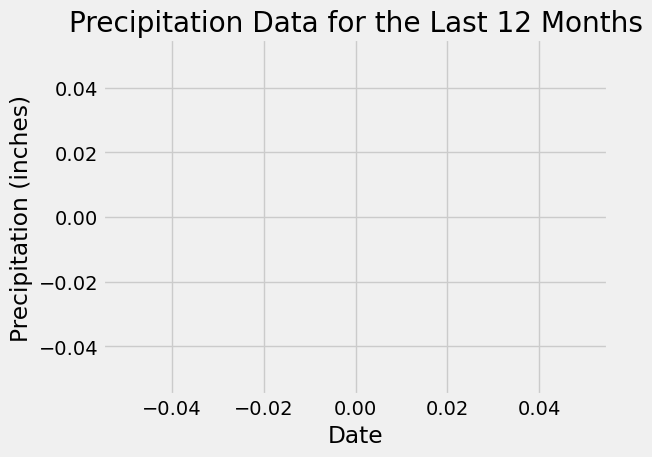

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(measurements_df['date'], measurements_df['precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurements_df.describe()

,date,precipitation
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count((Station.station))).scalar()
print(f"Total number of stations: {num_stations}")

Total number of stations: 9


In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()
# Print the temperature statistics
print(f"Lowest temperature: {temperature_stats[0][0]}")
print(f"Average temperature: {temperature_stats[0][1]}")
print(f"Highest temperature: {temperature_stats[0][2]}")


Lowest temperature: 54.0
Average temperature: 71.66378066378067
Highest temperature: 85.0


In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from datetime import datetime, timedelta
# most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date_tuple = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_tuple[0]
most_recent_date
# Calculate the start date for the last 12 months
start_date = one_year_ago_datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

temperature_data = session.query(Measurement.tobs).\
                   filter(Measurement.station == most_active_station, Measurement.date >= start_date).all()
temperature_list = [t[0] for t in temperature_data]
plt.hist(temperature_list, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Distribution for Station {most_active_station}')
plt.show()
temperature_data

AttributeError: 'numpy.ndarray' object has no attribute 'strptime'

# Close Session

In [16]:
# Close Session
session.close()